
# Download necessary packages

In [3]:
!pip install transformers
!pip install nltk
!pip install sklearn
!pip install gensim
!pip install torch
!pip install scikit-learn
!pip install gensim
!pip install torch
!pip install textblob
!pip install pyLDAvis
!pip install xformers
!pip install wordcloud
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 3.7 MB/s eta 0:00:0000:01


In [32]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

nltk.download('punkt') # download the necessary tokenizer
nltk.download('stopwords') # download the necessary stop words
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from gensim import corpora
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import string
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import random
import pickle
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
import pyLDAvis.gensim
from sklearn.manifold import TSNE
import gensim.downloader as api
from gensim.models import Word2Vec
from wordcloud import WordCloud
import time
import psutil
import os
from transformers import pipeline
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ucloud/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ucloud/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Data Loading

In [5]:
!git clone https://github.com/inesfrsantos/NLP

fatal: destination path 'NLP' already exists and is not an empty directory.


In [6]:
#Load bumble data
bumble = pd.read_csv('./NLP/Data Sources/bumble_google_play_reviews.csv')

In [7]:
#Load Tinder Data
with zipfile.ZipFile("./NLP/Data Sources/Tinder_reviews.zip", "r") as zip_ref:
    # Replace "path/to/your/file.csv" with the path to your CSV file within the ZIP archive
    with zip_ref.open("tinder_google_play_reviews.csv") as csv_file:
        # Load the CSV data into a Pandas DataFrame
        tinder = pd.read_csv(csv_file)

# Exploratory Data Analysis

In [8]:
# Check the bumble data
bumble.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129463 entries, 0 to 129462
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              129463 non-null  object
 1   userName              129463 non-null  object
 2   userImage             129463 non-null  object
 3   content               129449 non-null  object
 4   score                 129463 non-null  int64 
 5   thumbsUpCount         129463 non-null  int64 
 6   reviewCreatedVersion  108021 non-null  object
 7   at                    129463 non-null  object
 8   replyContent          84369 non-null   object
 9   repliedAt             84369 non-null   object
 10  appVersion            108021 non-null  object
dtypes: int64(2), object(9)
memory usage: 10.9+ MB


In [9]:
# Check the tinder data
tinder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584667 entries, 0 to 584666
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              584667 non-null  object
 1   userName              584663 non-null  object
 2   userImage             584667 non-null  object
 3   content               583302 non-null  object
 4   score                 584667 non-null  int64 
 5   thumbsUpCount         584667 non-null  int64 
 6   reviewCreatedVersion  463732 non-null  object
 7   at                    584667 non-null  object
 8   replyContent          47121 non-null   object
 9   repliedAt             47121 non-null   object
 10  appVersion            463732 non-null  object
dtypes: int64(2), object(9)
memory usage: 49.1+ MB


In [10]:
# Check the first rows of each the bumble data
bumble.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,d1b0a0e6-fd75-49a7-89b5-aceb3229b180,Pintu bhai mahla,https://play-lh.googleusercontent.com/a/AGNmyx...,Op level,3,0,5.317.1,2023-04-30 00:53:36,NaN,NaN,5.317.1
1,6f4869a0-2b49-43e9-bb8e-e4451345e29d,Abdul Basit,https://play-lh.googleusercontent.com/a/AGNmyx...,Badoo is way better,1,0,NaN,2023-04-30 00:09:08,NaN,NaN,NaN
2,bd8f6865-5481-4739-915f-d31ba2bb6430,Albert Fuentez,https://play-lh.googleusercontent.com/a/AGNmyx...,Far too many fake accounts and fluff matches i...,2,0,NaN,2023-04-30 00:06:16,NaN,NaN,NaN
3,68886f10-800f-4fd9-b2a1-91051614806f,ehit,https://play-lh.googleusercontent.com/a/AGNmyx...,Not using my right location. I'm traveling and...,1,0,5.317.1,2023-04-29 22:14:03,NaN,NaN,5.317.1
4,8874f001-332c-42fa-ae96-fc738eba8b4a,Christopher,https://play-lh.googleusercontent.com/a/AGNmyx...,Stopped working on my phone all together doesn...,1,0,5.317.1,2023-04-29 21:29:58,NaN,NaN,5.317.1


In [11]:
#Check the first rows of the tinder data
tinder.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,701f6eba-bd35-4d2e-8812-b7ba889c9204,Ricardo Morales,https://play-lh.googleusercontent.com/a-/ACB-R...,People use tinder to promote their IGs,1,0,14.7.0,2023-05-05 01:05:07,NaN,NaN,14.7.0
1,a551c9d2-d5d6-42df-80dd-3c3c0eb60766,This Man,https://play-lh.googleusercontent.com/a-/ACB-R...,Worst dating app,1,0,NaN,2023-05-05 00:59:39,NaN,NaN,NaN
2,f42dc157-ba8d-4957-820e-d73f1797bf1c,Mehul Shah,https://play-lh.googleusercontent.com/a-/ACB-R...,Good...,5,0,14.7.0,2023-05-05 00:38:48,NaN,NaN,14.7.0
3,9af363bc-d8ce-44b4-baf9-8f038beffe07,Adam Shehata,https://play-lh.googleusercontent.com/a/AGNmyx...,This is actually the worst dating app ever. Tr...,1,0,NaN,2023-05-05 00:34:06,NaN,NaN,NaN
4,e1446b4b-0a87-4822-84f8-5cc406a9a7aa,Miguel Alvarez,https://play-lh.googleusercontent.com/a/AGNmyx...,it's alright,2,0,14.7.0,2023-05-05 00:32:41,NaN,NaN,14.7.0


In [12]:
# Check missing values
bumble.isnull().sum()

reviewId                    0
userName                    0
userImage                   0
content                    14
score                       0
thumbsUpCount               0
reviewCreatedVersion    21442
at                          0
replyContent            45094
repliedAt               45094
appVersion              21442
dtype: int64

In [13]:
# Check missing values
tinder.isnull().sum()

reviewId                     0
userName                     4
userImage                    0
content                   1365
score                        0
thumbsUpCount                0
reviewCreatedVersion    120935
at                           0
replyContent            537546
repliedAt               537546
appVersion              120935
dtype: int64

In [14]:
# check the value count for ratings
print(bumble['score'].value_counts())
print(tinder['score'].value_counts())

score
1    54967
5    35985
4    15603
2    12021
3    10887
Name: count, dtype: int64
score
1    231164
5    198607
4     68165
3     45460
2     41270
0         1
Name: count, dtype: int64


In [15]:
# check 0 score for Tinder
tinder[tinder['score']==0]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
334053,bd305121-44f4-4dce-8d9b-3e324edccaef,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Love it but ...my match is not replying its a ...,0,0,9.0.0,2018-05-27 18:15:34,NaN,NaN,9.0.0


In [16]:
# delete score 0 row
tinder = tinder[tinder['score']!=0]

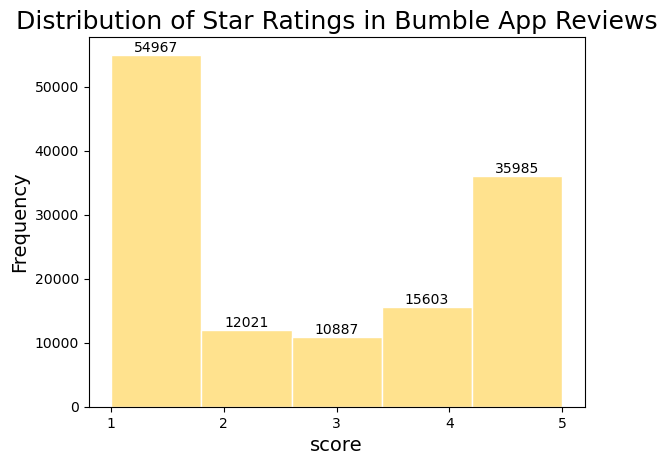

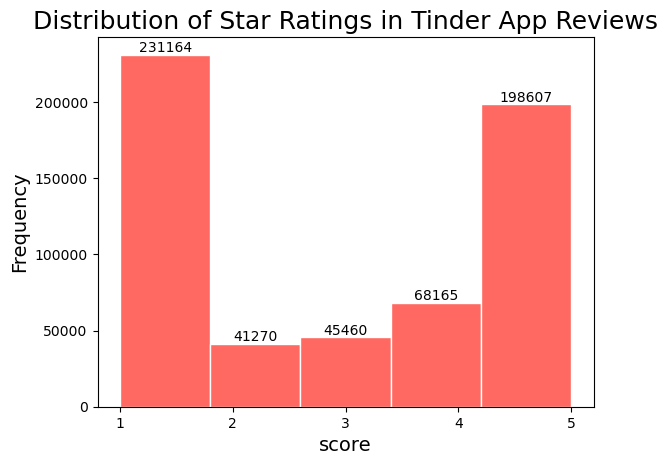

In [17]:
target_col = "score"

# Define the values in the "score" column
score_values = np.arange(1, 6)  # Assuming scores range from 1 to 5

# Plot the distribution of the target variable for Bumble
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(bumble[target_col], bins=5, color="#ffe28e", edgecolor="white")
ax.set_xlabel(target_col, fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Distribution of Star Ratings in Bumble App Reviews", fontsize=18)
ax.set_xticks(score_values)
ax.set_xticklabels(score_values)

# Label each bar with its frequency value
for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = count
    ax.text(x, y, str(int(count)), ha='center', va='bottom')

plt.show()

# Plot the distribution of the target variable for Tinder
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(tinder[target_col], bins=5, color="#ff6961", edgecolor="white")
ax.set_xlabel(target_col, fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Distribution of Star Ratings in Tinder App Reviews", fontsize=18)
ax.set_xticks(score_values)
ax.set_xticklabels(score_values)

# Label each bar with its frequency value
for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = count
    ax.text(x, y, str(int(count)), ha='center', va='bottom')

plt.show()

In [18]:
## Count the duplicates in the "reviewId" column for each dataset
tinder_duplicate_count = tinder.duplicated(subset='reviewId').sum()
bumble_duplicate_count = bumble.duplicated(subset='reviewId').sum()

# Print the count of duplicates for each dataset
print("Number of duplicates in Tinder dataset:", tinder_duplicate_count)
print("Number of duplicates in Bumble dataset:", bumble_duplicate_count)

Number of duplicates in Tinder dataset: 0
Number of duplicates in Bumble dataset: 0


In [19]:
# Check the maximum and minimum dates in the 'at' column of the Tinder dataset
tinder_max_date = tinder['at'].max()
tinder_min_date = tinder['at'].min()

# Check the maximum and minimum dates in the 'at' column of the Bumble dataset
bumble_max_date = bumble['at'].max()
bumble_min_date = bumble['at'].min()

# Print the results
print("Tinder Dataset:")
print("Maximum Date:", tinder_max_date)
print("Minimum Date:", tinder_min_date)
print()
print("Bumble Dataset:")
print("Maximum Date:", bumble_max_date)
print("Minimum Date:", bumble_min_date)

Tinder Dataset:
Maximum Date: 2023-05-05 01:05:07
Minimum Date: 2013-07-15 21:07:56

Bumble Dataset:
Maximum Date: 2023-04-30 00:53:36
Minimum Date: 2015-11-29 23:15:25


From the analysis above we can see that both datasets have the same number of columns and the same column names. Hence we will be merging the datasets. 

Furthermore as the most important column in our analysis is the "content", which contains the text to be analysed, we will be removing the rows that have null values for it, and the columns that will not be used. 

Additionally, some formatting in the tables will be conducted as well, such as lowering column names and other pre-processing needed before doing our modelling. 

Lastly, we will remove some of the data so both datasets are within the same period more or less.

# Pre-Processing

In [20]:
# Convert at to datetime
tinder['at'] = pd.to_datetime(tinder['at'])
bumble['at'] = pd.to_datetime(bumble['at'])

In [21]:
# Filter Tinder dataset to include data from 2015 onwards
tinder = tinder[tinder['at'].dt.year >= 2015]

In [22]:
# Create a new column called "app" and set its values to Bumble and Tinder so we classify it
bumble["app"] = "Bumble"
tinder["app"] = "Tinder"

In [23]:
# Concatenate the two datasets
app_reviews = pd.concat([bumble, tinder])

In [24]:
# Drop the null values for the content column
app_reviews = app_reviews.dropna(subset=['content'])

In [25]:
app_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app
0,d1b0a0e6-fd75-49a7-89b5-aceb3229b180,Pintu bhai mahla,https://play-lh.googleusercontent.com/a/AGNmyx...,Op level,3,0,5.317.1,2023-04-30 00:53:36,NaN,NaN,5.317.1,Bumble
1,6f4869a0-2b49-43e9-bb8e-e4451345e29d,Abdul Basit,https://play-lh.googleusercontent.com/a/AGNmyx...,Badoo is way better,1,0,NaN,2023-04-30 00:09:08,NaN,NaN,NaN,Bumble
2,bd8f6865-5481-4739-915f-d31ba2bb6430,Albert Fuentez,https://play-lh.googleusercontent.com/a/AGNmyx...,Far too many fake accounts and fluff matches i...,2,0,NaN,2023-04-30 00:06:16,NaN,NaN,NaN,Bumble
3,68886f10-800f-4fd9-b2a1-91051614806f,ehit,https://play-lh.googleusercontent.com/a/AGNmyx...,Not using my right location. I'm traveling and...,1,0,5.317.1,2023-04-29 22:14:03,NaN,NaN,5.317.1,Bumble
4,8874f001-332c-42fa-ae96-fc738eba8b4a,Christopher,https://play-lh.googleusercontent.com/a/AGNmyx...,Stopped working on my phone all together doesn...,1,0,5.317.1,2023-04-29 21:29:58,NaN,NaN,5.317.1,Bumble


In [26]:
# Remove columns that are not needed
#Select columns
columns_to_remove = ["reviewCreatedVersion", "at", "replyContent", "repliedAt", "appVersion", "userImage", "thumbsUpCount"]

# Drop the specified columns
app_reviews = app_reviews.drop(columns_to_remove, axis=1)

In [27]:
# Lowercase all column names and remove extra whitespaces
app_reviews.columns = app_reviews.columns.map(str.lower).map(str.strip)

In [28]:
# Define a function to clean text
def clean_text(text):
    clean_text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return clean_text

# Apply the clean_text function to the content column
app_reviews['content'] = app_reviews['content'].apply(clean_text)

#### Tokenizing 

In [29]:
# create a new column 'tokens' by tokenizing the 'text' column
app_reviews['tokens'] = app_reviews['content'].apply(nltk.word_tokenize)

# convert all tokens to lowercase
app_reviews['tokens'] = app_reviews['tokens'].apply(lambda x: [word.lower() for word in x])

### POS Tagging

In [33]:
app_reviews_pos = app_reviews.copy()

# apply POS tagging + filter adjectives
# set of POS tags to remove
pos_to_remove ={'JJ', 'JJR', 'JJS'}

# Perform POS tagging and remove adjectives
app_reviews_pos['filtered_tokens'] = app_reviews_pos['tokens'].apply(pos_tag)
app_reviews_pos['filtered_tokens'] = app_reviews_pos['filtered_tokens'].apply(lambda x: [token for token, pos in x if pos not in pos_to_remove])

#### Removing Stop Words

In [ ]:
# create a set of stop words
stop_words = set(stopwords.words('english'))

# remove stop words from the 'tokens' column
app_reviews['tokens'] = app_reviews['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# remove stop words from the 'filtered_tokens' column
app_reviews_pos['filtered_tokens'] = app_reviews_pos['filtered_tokens'].apply(lambda x: [word for word in x if word not in stop_words])

#### Lemmatizing

In [ ]:
# Initialize Lemmatizer
lemmatizer  = WordNetLemmatizer() 

In [ ]:
# Define a function to apply lemmatization to a list of tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

In [ ]:
# Apply lemmatization to a column of tokens in a dataframe
app_reviews['lemmatized_tokens'] = app_reviews['tokens'].apply(lemmatize_tokens)
app_reviews_pos['lemmatized_tokens'] = app_reviews_pos['filtered_tokens'].apply(lemmatize_tokens)

In [ ]:
# Remove rows with empty list of filtered tokens
empty_tokens = app_reviews_pos[app_reviews_pos['filtered_tokens'].map(lambda x: len(x)==0)]
print(f'Among {len(app_reviews)} rows, removing {len(empty_tokens)} empty rows.')
app_reviews_pos = app_reviews_pos[app_reviews_pos['filtered_tokens'].map(lambda x: len(x)>0)]

Among 669004 rows, removing 64064 empty rows.


In [ ]:
# save the result
app_reviews.to_csv('app_reviews_preprocessed.csv')

### WordCloud

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


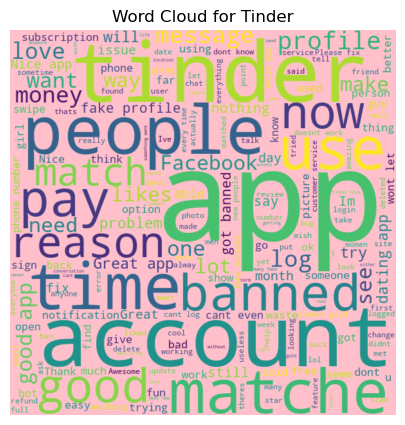

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


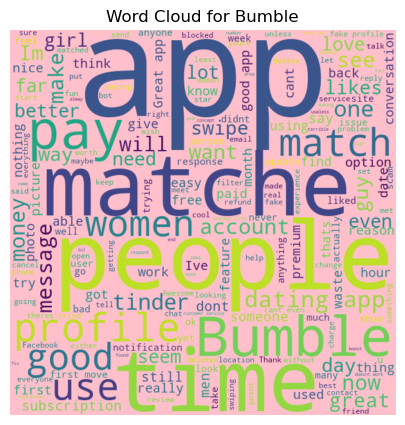

In [ ]:
# Filter rows for 'tinder' app
tinder_text = ' '.join(app_reviews[app_reviews['app'] == 'Tinder']['content'])

# Generate word cloud for 'tinder' app
tinder_wordcloud = WordCloud(width=600, height=600, background_color='pink').generate(tinder_text)

# Plot the 'tinder' word cloud
plt.figure(figsize=(10, 5))
plt.imshow(tinder_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Tinder')
plt.show()


# Filter rows for 'bumble' app
bumble_text = ' '.join(app_reviews[app_reviews['app'] == 'Bumble']['content'])

# Generate word cloud for 'bumble' app
bumble_wordcloud = WordCloud(width=600, height=600, background_color='pink').generate(bumble_text)

# Plot the 'bumble' word cloud
plt.figure(figsize=(10, 5))
plt.imshow(bumble_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Bumble')
plt.show()

# LDA

### Grid Search
* Without POS tagging

In [39]:
text_corpus = app_reviews['lemmatized_tokens']

# Create dictionary
dictionary = corpora.Dictionary(text_corpus)

# Create bag of words corpus
corpus = [dictionary.doc2bow(doc) for doc in text_corpus]

In [41]:
num_topics = [3,5,7]
alpha_values = ['symmetric', 'asymmetric']
beta_values = [0.1, 1.0]
seed_value = 42

best_coherence = -float('inf')
best_model = None
best_alpha = None
best_beta = None

# Generate combinations of alpha, beta, and num_topics
combinations = itertools.product(alpha_values, beta_values, num_topics)

# Iterate over the combinations
for a, b, n in combinations:
    # Train LDA model with current hyperparameters
    lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary, random_state=seed_value, alpha=a, eta=b, passes=5)

    # Calculate coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=text_corpus, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()

    if coherence > best_coherence:
        best_coherence = coherence
        best_model = lda_model
        best_num_topics = n
        best_alpha = a
        best_beta = b

In [43]:
print(f'Best topic number is {best_num_topics}')
print(f'Best alpha is {best_alpha}')
print(f'Best beta is {best_beta}')

LdaModel<num_terms=114230, num_topics=3, decay=0.5, chunksize=2000>
0.657230335945026
3
asymmetric
0.1


* With POS tagging + Removing adjectives

In [42]:
text_corpus = app_reviews_pos['lemmatized_tokens']

# Create dictionary
dictionary = corpora.Dictionary(text_corpus)

# Create bag of words corpus
corpus = [dictionary.doc2bow(doc) for doc in text_corpus]

In [45]:
num_topics = [3,5,7]
alpha_values = ['symmetric', 'asymmetric']
beta_values = [0.1, 1.0]
seed_value = 42


best_coherence = -float('inf')
best_model = None
best_alpha = None
best_beta = None

# Generate combinations of alpha, beta, and num_topics
combinations = itertools.product(alpha_values, beta_values, num_topics)

# Iterate over the combinations
for a, b, n in combinations:
    # Train LDA model with current hyperparameters
    lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary, random_state=seed_value, alpha=a, eta=b, passes=5)

    # Calculate coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=text_corpus, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()

    if coherence > best_coherence:
        best_coherence = coherence
        best_model = lda_model
        best_num_topics = n
        best_alpha = a
        best_beta = b

In [130]:
print(f'Best topic number is {best_num_topics}')
print(f'Best alpha is {best_alpha}')
print(f'Best beta is {best_beta}')
print(f'Coherence score is {best_coherence}')

Best topic number is 3
Best alpha is symmetric
Best beta is 0.1
Coherence score is 0.6709627815974563


In [43]:
num_topics =3
alpha= 'symmetric'
beta=0.1

# Train LDA model
lda_model = LdaModel(corpus, 
                     num_topics=num_topics, 
                     id2word=dictionary, 
                     random_state = 42,
                     alpha=alpha, 
                     eta=beta, 
                     passes=5)

In [44]:
# Get the topics and their associated keywords
topics = lda_model.show_topics(num_topics=num_topics, num_words=20)
for topic in topics:
    print(f'topic{topic[0]}: \n',topic[1])

topic0: 
 0.046*"match" + 0.031*"get" + 0.027*"message" + 0.025*"time" + 0.022*"tinder" + 0.014*"one" + 0.013*"day" + 0.013*"got" + 0.012*"never" + 0.012*"profile" + 0.011*"month" + 0.011*"bot" + 0.010*"star" + 0.009*"im" + 0.009*"back" + 0.008*"5" + 0.008*"even" + 0.008*"notification" + 0.008*"dont" + 0.008*"would"
topic1: 
 0.047*"people" + 0.046*"app" + 0.045*"like" + 0.018*"love" + 0.018*"pay" + 0.017*"way" + 0.015*"fun" + 0.014*"really" + 0.014*"use" + 0.013*"meet" + 0.012*"tinder" + 0.011*"lot" + 0.010*"swipe" + 0.010*"find" + 0.009*"dont" + 0.009*"make" + 0.009*"want" + 0.008*"would" + 0.008*"girl" + 0.008*"far"
topic2: 
 0.060*"app" + 0.032*"facebook" + 0.024*"cant" + 0.023*"log" + 0.022*"work" + 0.017*"wont" + 0.017*"phone" + 0.017*"fix" + 0.017*"keep" + 0.016*"let" + 0.015*"problem" + 0.015*"even" + 0.014*"time" + 0.014*"try" + 0.013*"use" + 0.012*"number" + 0.012*"code" + 0.012*"please" + 0.011*"update" + 0.011*"sign"


* Topic 0: Matching and Message
* Topic 1: App Features and Functionality
* Topic 2: App Technical Issues

In [ ]:
# Define the topic themes based on the previous interpretation
topic_themes = {
   0: 'Matching and Message',
   1: 'App Features and Functionality',
   2: 'App Technical Issues',
}

### Evaluate LDA

* Coherence Score

In [ ]:
# Compute coherence score
coherence_model = CoherenceModel(
    model=lda_model,
    texts=app_reviews_pos['lemmatized_tokens'],
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)

Coherence Score: 0.6709627815974563


Coherence score is to assess how coherent and meaningful the topics are based on the co-occurrence of words within the same topic.
 Coherence scores above 0.5 are generally considered good and indicate reasonably coherent topics.
 A coherence score of 0.67 suggests moderate coherence in the generated topics.

* Topic Distance Map

In [ ]:
# LDA topic distance map
# Topics are represented as circles, and their proximity indicates their similarity.
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [49]:
# Save the LDA topic distance map asan HTML file
pyLDAvis.save_html(vis_data, 'topic_distance_map.html')

* Compare with Word2Vec

In [183]:
# Train a Word2Vec model
word2vec_model = Word2Vec(app_reviews_pos['lemmatized_tokens'], vector_size=100, window=5, min_count=1, sg=1)

In [184]:
# Extract topic keywords
topic_words = {}
for topic in topics:
    topic_id = topic[0]
    keywords = topic[1].split(' + ')
    words = [keyword.split('*')[1].replace('"', '') for keyword in keywords]
    topic_words[f'topic{topic_id}'] = words

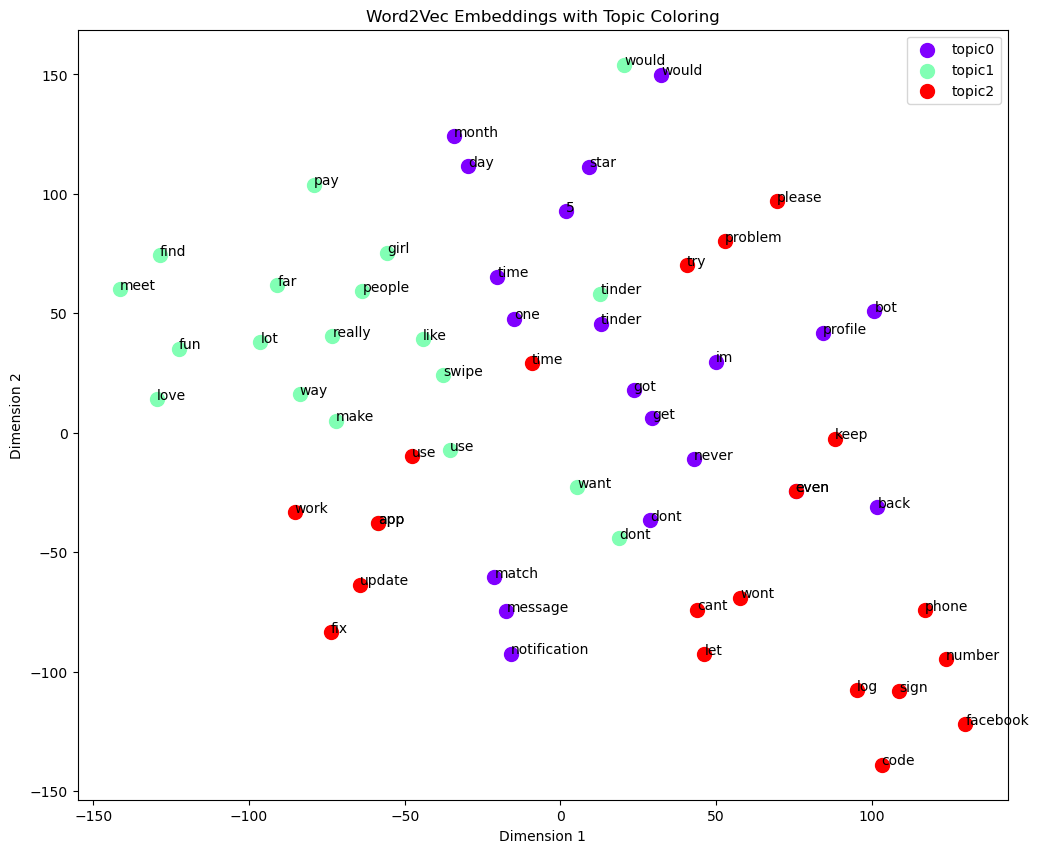

In [185]:
# Retrieve word embeddings for selected words
word_embeddings = [word2vec_model.wv[word] for topic_words in topic_words.values() for word in topic_words]

# Convert to 2D array
word_embeddings = np.array(word_embeddings)

# Apply dimensionality reduction
reduced_embeddings = TSNE(n_components=2, perplexity=10).fit_transform(word_embeddings)

# Define colors for each topic
colors = plt.cm.rainbow(np.linspace(0, 1, len(topic_words)))

# Adjust the size of scatter points and figure size
plt.figure(figsize=(12, 10))
scatter_size = 100

for i, (topic, words) in enumerate(topic_words.items()):
    x = reduced_embeddings[i * len(words): (i + 1) * len(words), 0]
    y = reduced_embeddings[i * len(words): (i + 1) * len(words), 1]
    plt.scatter(x, y, s=scatter_size, color=colors[i], label=topic)
    for j, word in enumerate(words):
        plt.annotate(word, (x[j], y[j]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word2Vec Embeddings with Topic Coloring')
plt.legend()
plt.show()


### Calculate topic probabilities for each document

In [186]:
# Assign topics to each document
# Get the probability how likely the document is assigned to each topic
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Extract the dominant topic and its probability for each document
dominant_topics = [(doc_id, max(topics, key=lambda x: x[1])) for doc_id, topics in enumerate(document_topics)]

# Make a list of topic
topic_assignments = [topic[0] for _, topic in dominant_topics]

# Maek a list of probability
topic_probs = [topic[1] for _, topic in dominant_topics]

In [187]:
# Save the topic label in the dataframe
app_reviews_pos['topic_prob'] = document_topics
app_reviews_pos['dominant_topic'] = topic_assignments
app_reviews_pos['dominant_prob'] = topic_probs

In [188]:
# Map the numeric column to text themes using the topic_themes dictionary
app_reviews_pos['topic_label'] = app_reviews_pos['dominant_topic'].map(topic_themes)

In [189]:
# Sav the dataframe after lda 
app_reviews_pos.to_csv('app_reviews_lda.csv')

# Save the LDA model
lda_model.save("lda_model")

### Topic Distribution plot

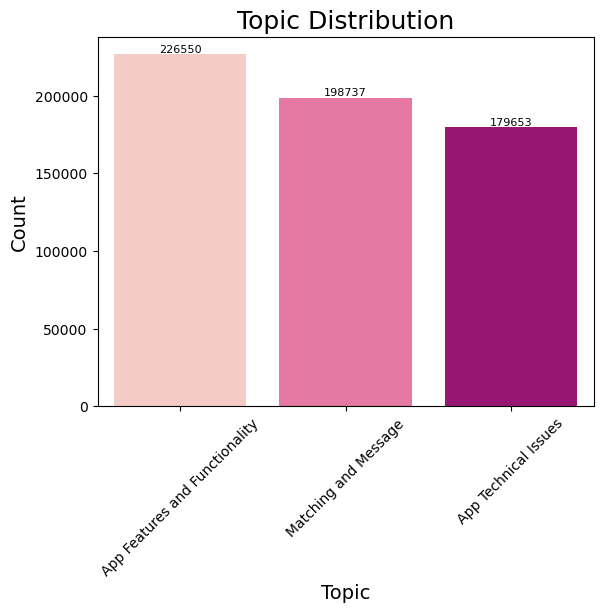

In [190]:
# Count the occurrences of a specific topic
topic_count = app_reviews_pos['topic_label'].value_counts()

# Create a bar plot using seaborn with custom colors
sns.set_palette(sns.color_palette("RdPu", len(topic_count)))
sns.barplot(x=topic_count.index, y=topic_count.values)

# Set the labels for x-axis and y-axis
plt.xlabel('Topic',fontsize=14)
plt.ylabel('Count', fontsize=14)

# Set the title of the bar plot
plt.title('Topic Distribution',fontsize=18 )

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add count labels above each bar
for p in plt.gca().patches:
      count = int(p.get_height())
      plt.gca().annotate(f"{count}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom',fontsize=8)

# Show the bar plot
plt.show()

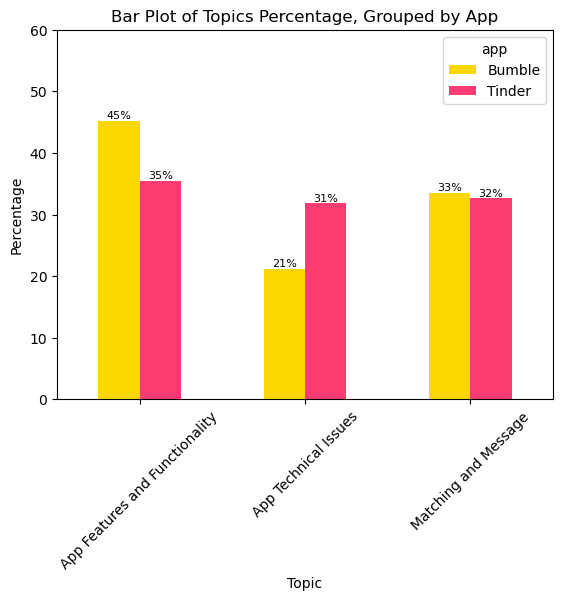

In [191]:
# Count the occurrences of a specific topic, grouped by the 'app' column
label_counts = app_reviews_pos.groupby(['topic_label', 'app']).size().unstack()

# Calculate the percentage of the total for each 'app' count
total_counts = label_counts.sum()
percentage_label_counts = label_counts.divide(total_counts, axis=1) * 100

# Create a custom color palette with yellow and pink
custom_palette = ['#FFD700', '#FE3C72']

# Create a bar plot using seaborn with custom colors
sns.set_palette(custom_palette)
percentage_label_counts.plot(kind='bar')

# Set the labels for x-axis and y-axis
plt.xlabel('Topic')
plt.ylabel('Percentage')
plt.ylim(0, 60) 
plt.xticks(rotation=45)

# Set the title of the bar plot
plt.title('Bar Plot of Topics Percentage, Grouped by App')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add count labels above each bar
for p in plt.gca().patches:
    count = int(p.get_height())
    plt.gca().annotate(f"{count}%", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom',fontsize=8)

# Show the bar plot
plt.show()

### Check Random Sample Sentences and Assigned topic

In [192]:
# Check random samples 
# Select five random document indices
random_indices = random.sample(range(app_reviews_pos.index[-1]), k=5)

# Print the content and corresponding topic for each random document
for doc_id in random_indices:
    content = app_reviews_pos['content'][doc_id]
    topic_id = app_reviews_pos['topic_label'][doc_id]
    topic_prob = app_reviews_pos['dominant_prob'][doc_id]
    dominant_topics[doc_id][1]
    print(f"Document {doc_id}: Content: {content}")
    print(f"Topic: {topic_id}")
    print(f"probability: {topic_prob}")
    print()

Document 26225: Content: a whole lot of huge chicks and only ones that match are way to far to even entertain the though of meeting maybe ppl just arent into big orange dudes
Topic: App Features and Functionality
probability: 0.5754184722900391

Document 288389: Content: cant log in
Topic: App Technical Issues
probability: 0.6666651368141174

Document 256787: Content: unable to login error code 40120 please give solution
Topic: App Technical Issues
probability: 0.8888853788375854

Document 234053: Content: this app is terrible i got banned for no absolute reason the very first time i signed in
Topic: Matching and Message
probability: 0.7442707419395447

Document 146316: Content: I cant login on my account ever since I change phone what is d problem Should I jus 4get dis app or what
Topic: App Technical Issues
probability: 0.8338965773582458



# Sentiment Analysis

## VADER

In [93]:
# set the seed
random.seed(42)

In [94]:
# Initialize analyzer
vader = SentimentIntensityAnalyzer()

In [150]:
# Start the timer
start_time = time.perf_counter()
# Get initial CPU times
initial_cpu_times = psutil.cpu_times()
# Get the current process ID
process_id = psutil.Process().pid

# Perform sentiment analysis using VADER
app_reviews_pos['vader_score'] = app_reviews_pos['lemmatized_tokens'].apply(lambda x: vader.polarity_scores(' '.join(x))['compound'])


# Stop the timer
end_time = time.perf_counter()
# Get final CPU times
final_cpu_times = psutil.cpu_times()
# Get the memory usage of the current process
memory_info = psutil.Process(process_id).memory_info()

In [151]:
# Calculate running time
running_time_vader = (end_time - start_time) / 60

# Calculate CPU usage
cpu_user_time = final_cpu_times.user - initial_cpu_times.user
cpu_system_time = final_cpu_times.system - initial_cpu_times.system
cpu_idle_time = final_cpu_times.idle - initial_cpu_times.idle

total_cpu_time = cpu_user_time + cpu_system_time + cpu_idle_time
cpu_usage_vader = (cpu_user_time + cpu_system_time) / total_cpu_time

# Calculate the absolute memory usage in bytes
absolute_memory_usage_vader = memory_info.rss

# Convert the memory usage to a human-readable format
memory_usage_human_vader = psutil._common.bytes2human(absolute_memory_usage_vader)

# Print the results
print("Running Time: {:.2f} minutes".format(running_time_vader))
print("CPU Usage: {:.2f} seconds".format(cpu_usage_vader))
print("Absolute Memory Usage: {} ({} bytes)".format(memory_usage_human_vader, absolute_memory_usage_vader))

Running Time: 0.91 minutes
CPU Usage: 0.04 seconds
Absolute Memory Usage: 5.2G (5566816256 bytes)


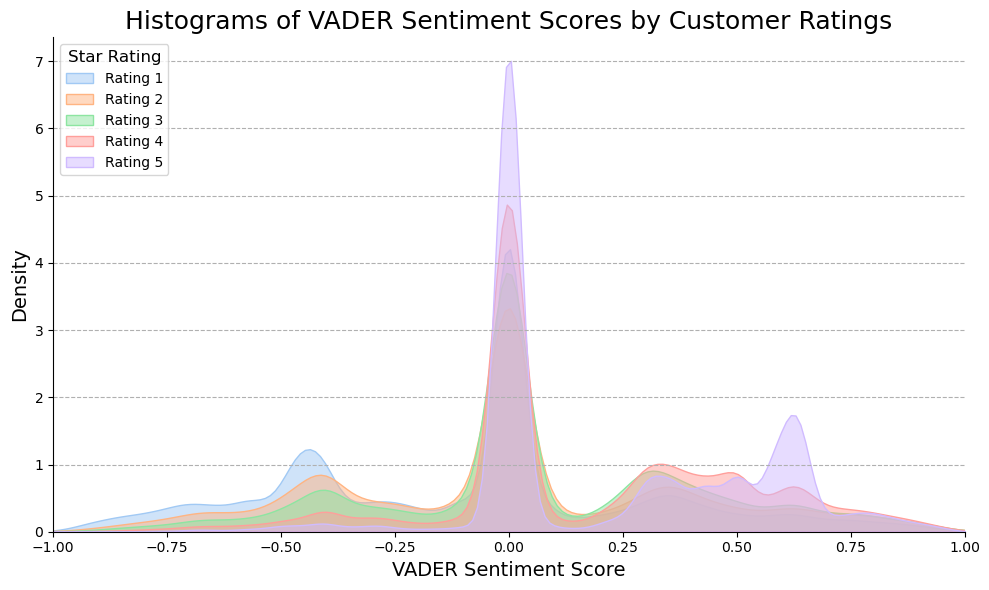

In [152]:
# Set the color palette for the histograms with pastel colors
colors = sns.color_palette("pastel", len(app_reviews_pos['score'].unique()))

# Plot separate histograms for each customer rating
plt.figure(figsize=(10, 6))
for i, rating in enumerate(sorted(app_reviews_pos['score'].unique())):
    subset = app_reviews_pos[app_reviews_pos['score'] == rating]
    sns.kdeplot(data=subset, x='vader_score', common_norm=False, fill=True,
                alpha=0.5, label=f"Rating {rating}", color=colors[i])

# Set the x-axis range
plt.xlim(-1, 1)

# Set the plot labels and title
plt.xlabel("VADER Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Histograms of VADER Sentiment Scores by Customer Ratings", fontsize=18)

# Add a legend with a title
legend = plt.legend(title='Star Rating', loc='upper left')
plt.setp(legend.get_title(), fontsize=12)

# Remove the top and right spines
sns.despine()

# Add grid lines
plt.grid(axis='y', linestyle='--')

# Adjust plot margins
plt.tight_layout()

# Show the plot
plt.show()

In [153]:
#Define Vader function 
def get_vader_sentiment(score):
    if score > 0.001:
        return 'Positive'
    elif score < -0.001:
        return 'Negative'
    else:
        return 'Neutral'

app_reviews_pos['vader_sentiment'] = app_reviews_pos['vader_score'].apply(get_vader_sentiment)

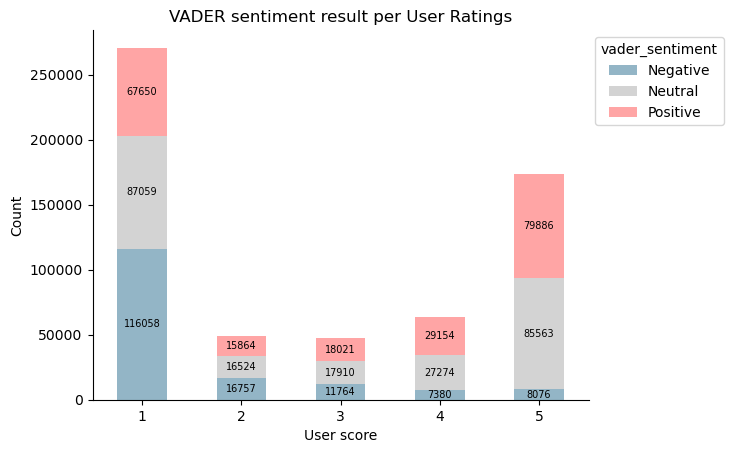

In [206]:
# Count the occurrences of a specific topic, grouped by the Roberta sentiment column
counts = app_reviews_pos.groupby(['score', 'vader_sentiment']).size().unstack()

# Create a custom color palette with yellow and pink
custom_palette = ['#93B5C6', '#D3D3D3', '#FFA5A5']

# Create a bar plot using seaborn with custom colors
sns.set_palette(custom_palette)
ax=counts.plot(kind='bar', stacked=True)

# Set the labels for x-axis and y-axis
plt.xlabel('User score')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add count labels inside each bar
for i, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2
    count = counts.transpose().values.flatten()[i]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=7)


# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the title of the bar plot
plt.title('VADER sentiment result per User Ratings')
# Move the legend to the bottom
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='vader_sentiment')
# Show the bar plot
plt.show()

## TextBlob

In [156]:
# Start the timer
start_time = time.perf_counter()
# Get initial CPU times
initial_cpu_times = psutil.cpu_times()
# Get the current process ID
process_id = psutil.Process().pid

# Perform sentiment analysis using TextBlob
app_reviews_pos['textblob_score'] = app_reviews_pos['lemmatized_tokens'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

# Stop the timer
end_time = time.perf_counter()
# Get final CPU times
final_cpu_times = psutil.cpu_times()
# Get the memory usage of the current process
memory_info = psutil.Process(process_id).memory_info()

In [157]:
# Calculate running time
running_time_textblob = (end_time - start_time) / 60

# Calculate CPU usage
cpu_user_time = final_cpu_times.user - initial_cpu_times.user
cpu_system_time = final_cpu_times.system - initial_cpu_times.system
cpu_idle_time = final_cpu_times.idle - initial_cpu_times.idle

total_cpu_time = cpu_user_time + cpu_system_time + cpu_idle_time
cpu_usage_textblob = (cpu_user_time + cpu_system_time) / total_cpu_time

# Calculate the absolute memory usage in bytes
absolute_memory_usage_textblob = memory_info.rss

# Convert the memory usage to a human-readable format
memory_usage_human_textblob = psutil._common.bytes2human(absolute_memory_usage_textblob)

# Print the results
print("Running Time: {:.2f} minutes".format(running_time_textblob))
print("CPU Usage: {:.2f} seconds".format(cpu_usage_textblob))
print("Absolute Memory Usage: {} ({} bytes)".format(memory_usage_human_textblob, absolute_memory_usage_textblob))

Running Time: 1.16 minutes
CPU Usage: 0.04 seconds
Absolute Memory Usage: 5.2G (5566853120 bytes)


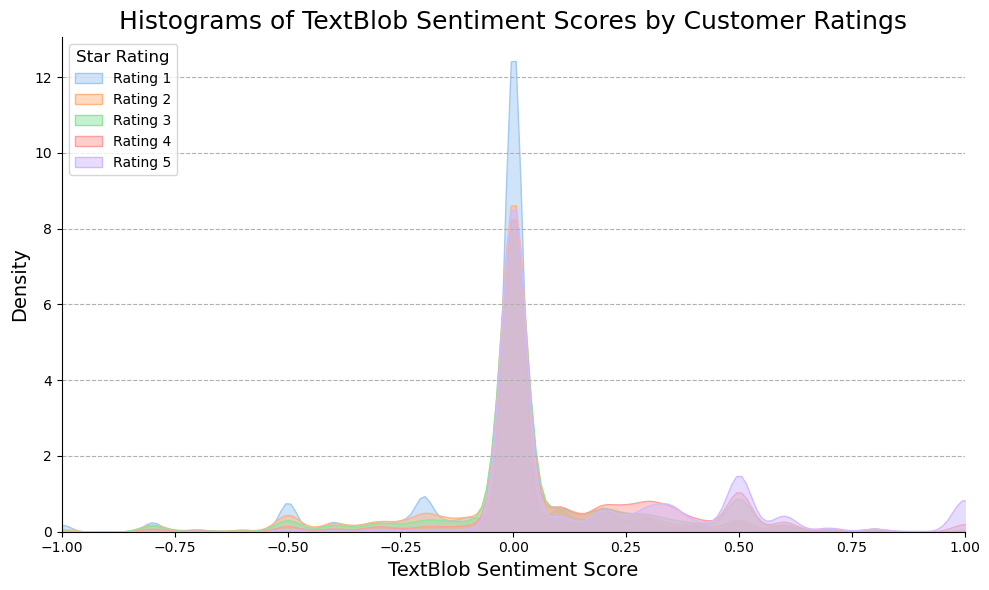

In [158]:
# Set the color palette for the histograms with pastel colors
colors = sns.color_palette("pastel", len(app_reviews_pos['score'].unique()))

# Plot separate histograms for each customer rating
plt.figure(figsize=(10, 6))
for i, rating in enumerate(sorted(app_reviews_pos['score'].unique())):
    subset = app_reviews_pos[app_reviews_pos['score'] == rating]
    sns.kdeplot(data=subset, x='textblob_score', common_norm=False, fill=True,
              alpha=0.5, label=f"Rating {rating}", color=colors[i])

# Set the x-axis range
plt.xlim(-1, 1)

# Set the plot labels and title
plt.xlabel("TextBlob Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Histograms of TextBlob Sentiment Scores by Customer Ratings", fontsize=18)

# Add a legend with a title
legend = plt.legend(title='Star Rating', loc='upper left')
plt.setp(legend.get_title(), fontsize=12)

# Remove the top and right spines
sns.despine()

# Add grid lines
plt.grid(axis='y', linestyle='--')

# Adjust plot margins
plt.tight_layout()

# Show the plot
plt.show()

In [159]:
def get_textblob_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

app_reviews_pos['textblob_sentiment'] = app_reviews_pos['textblob_score'].apply(get_textblob_sentiment)

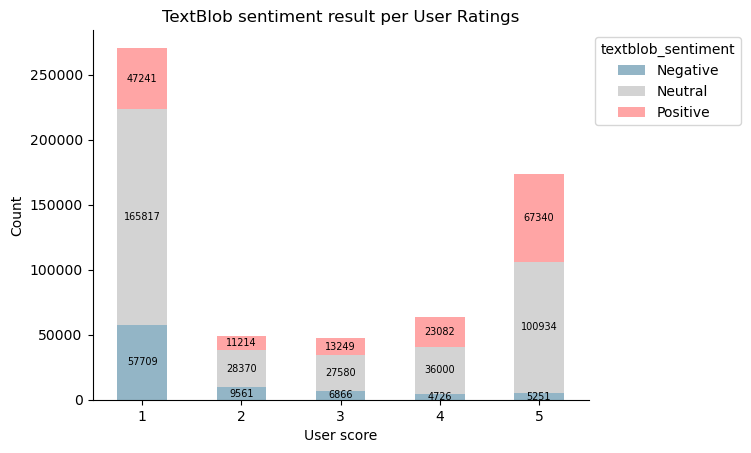

In [207]:
# Count the occurrences of a specific topic, grouped by the Roberta sentiment column
counts = app_reviews_pos.groupby(['score', 'textblob_sentiment']).size().unstack()

# Create a custom color palette 
custom_palette = ['#93B5C6', '#D3D3D3', '#FFA5A5']

# Create a bar plot using seaborn with custom colors
sns.set_palette(custom_palette)
ax=counts.plot(kind='bar', stacked=True)

# Set the labels for x-axis and y-axis
plt.xlabel('User score')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add count labels inside each bar
for i, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2
    count = counts.transpose().values.flatten()[i]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=7)


# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the title of the bar plot
plt.title('TextBlob sentiment result per User Ratings')
# Move the legend to the bottom
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='textblob_sentiment')
# Show the bar plot
plt.show()

## RoBERTa

In [82]:
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

In [83]:
def get_roberta_sentiment(text):
    result = sentiment_analysis(text)[0]
    label = result['label']
    score = result['score']
    return label, score

In [104]:
# Start the timer
start_time = time.perf_counter()
# Get initial CPU times
initial_cpu_times = psutil.cpu_times()
# Get the current process ID
process_id = psutil.Process().pid

#Apply Roberta
app_reviews_pos['roberta_sentiment'] = app_reviews_pos['lemmatized_tokens'].apply(lambda tokens: get_roberta_sentiment(' '.join(tokens)))

# Stop the timer
end_time = time.perf_counter()
# Get final CPU times
final_cpu_times = psutil.cpu_times()
# Get the memory usage of the current process
memory_info = psutil.Process(process_id).memory_info()

In [105]:
# Calculate running time
running_time_roberta = (end_time - start_time) / 60

# Calculate CPU usage
cpu_user_time = final_cpu_times.user - initial_cpu_times.user
cpu_system_time = final_cpu_times.system - initial_cpu_times.system
cpu_idle_time = final_cpu_times.idle - initial_cpu_times.idle

total_cpu_time = cpu_user_time + cpu_system_time + cpu_idle_time
cpu_usage_roberta = (cpu_user_time + cpu_system_time) / total_cpu_time

# Calculate the absolute memory usage in bytes
absolute_memory_usage_roberta = memory_info.rss

# Convert the memory usage to a human-readable format
memory_usage_human_roberta = psutil._common.bytes2human(absolute_memory_usage_roberta)

# Print the results
print("Running Time: {:.2f} minutes".format(running_time_roberta))
print("CPU Usage: {:.2f} seconds".format(cpu_usage_roberta))
print("Absolute Memory Usage: {} ({} bytes)".format(memory_usage_human_roberta, absolute_memory_usage_roberta))

Running Time: 544.28 minutes
CPU Usage: 0.26 seconds
Absolute Memory Usage: 5.1G (5482672128 bytes)


In [106]:
# Map sentiment labels to positive, negative, or neutral
sentiment_mapping = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}

# Create new columns 'roberta_sentiment' and 'roberta_score' based on 'roberta_sentiment' column
app_reviews_pos['roberta_sentiment_1'], app_reviews_pos['roberta_score'] = zip(*app_reviews_pos['roberta_sentiment'].apply(lambda x: (sentiment_mapping[x[0]], x[1])))

# Remove the original 'roberta_sentiment' column
app_reviews_pos.drop('roberta_sentiment', axis=1, inplace=True)

# Rename the 'roberta_sentiment' column to 'roberta_sentiment_1'
app_reviews_pos.rename(columns={'roberta_sentiment_1': 'roberta_sentiment'}, inplace=True)


In [148]:
# Save the dataframe after roberta 
app_reviews_pos.to_csv('app_reviews_roberta.csv')

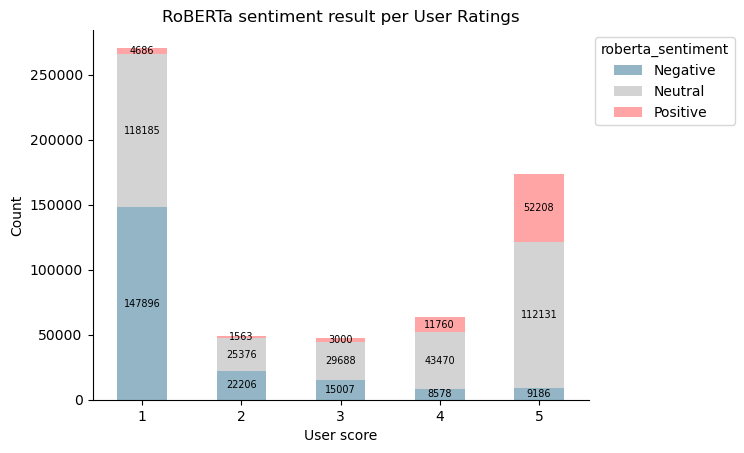

In [208]:
# Count the occurrences of a specific topic, grouped by the Roberta sentiment column
counts = app_reviews_pos.groupby(['score', 'roberta_sentiment']).size().unstack()

# Create a custom color palette 
custom_palette = ['#93B5C6', '#D3D3D3', '#FFA5A5']

# Create a bar plot using seaborn with custom colors
sns.set_palette(custom_palette)
ax=counts.plot(kind='bar', stacked=True)

# Set the labels for x-axis and y-axis
plt.xlabel('User score')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add count labels inside each bar
for i, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2
    count = counts.transpose().values.flatten()[i]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=7)


# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the title of the bar plot
plt.title('RoBERTa sentiment result per User Ratings')
# Move the legend to the bottom
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='roberta_sentiment')
# Show the bar plot
plt.show()

In [109]:
# Compute the confusion matrix for TextBlob
textblob_confusion = confusion_matrix(app_reviews_pos['roberta_sentiment'], app_reviews_pos['textblob_sentiment'])

# Compute the confusion matrix for Vader
vader_confusion = confusion_matrix(app_reviews_pos['roberta_sentiment'], app_reviews_pos['vader_sentiment'])

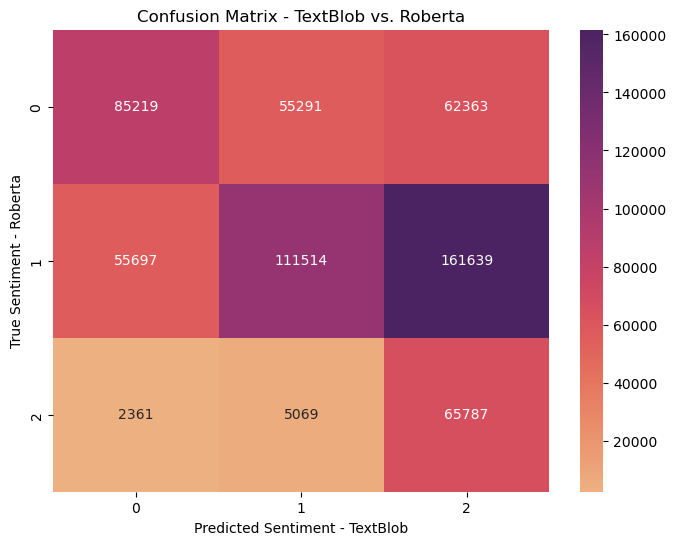

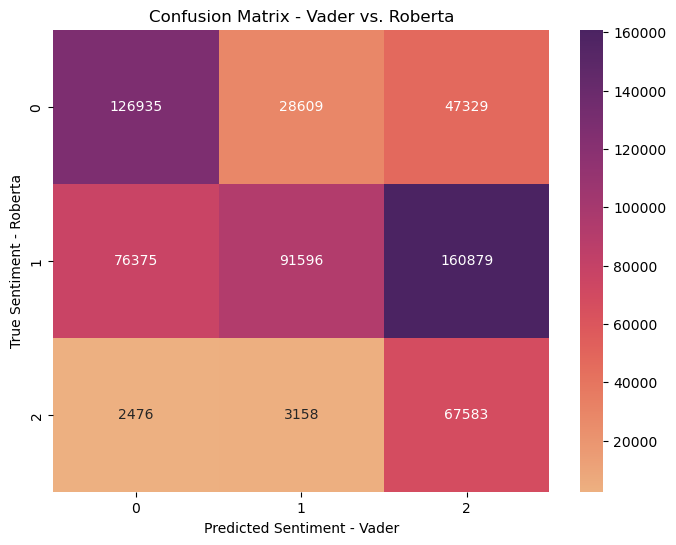

In [177]:
# Plot the confusion matrix for TextBlob
plt.figure(figsize=(8, 6))
sns.heatmap(textblob_confusion, annot=True, fmt='d', cmap='flare', cbar=True)
plt.title('Confusion Matrix - TextBlob vs. Roberta')
plt.xlabel('Predicted Sentiment - TextBlob')
plt.ylabel('True Sentiment - Roberta')
plt.show()

# Plot the confusion matrix for Vader
plt.figure(figsize=(8, 6))
sns.heatmap(vader_confusion, annot=True, fmt='d', cmap='flare', cbar=True)
plt.title('Confusion Matrix - Vader vs. Roberta')
plt.xlabel('Predicted Sentiment - Vader')
plt.ylabel('True Sentiment - Roberta')
plt.show()

In [167]:
# Calculate the classification report for TextBlob
textblob_report = classification_report(app_reviews_pos['roberta_sentiment'], app_reviews_pos['textblob_sentiment'], target_names=['Negative', 'Neutral', 'Positive'])

# Calculate the classification report for Vader
vader_report = classification_report(app_reviews_pos['roberta_sentiment'], app_reviews_pos['vader_sentiment'], target_names=['Negative', 'Neutral', 'Positive'])

print("TextBlob Classification Report:")
print(textblob_report)
print()

print("Vader Classification Report:")
print(vader_report)

TextBlob Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.31      0.44    202873
     Neutral       0.68      0.75      0.71    328850
    Positive       0.39      0.86      0.54     73217

    accuracy                           0.61    604940
   macro avg       0.61      0.64      0.56    604940
weighted avg       0.67      0.61      0.60    604940


Vader Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.59      0.66    202873
     Neutral       0.81      0.58      0.68    328850
    Positive       0.32      0.93      0.48     73217

    accuracy                           0.63    604940
   macro avg       0.63      0.70      0.61    604940
weighted avg       0.73      0.63      0.65    604940



In [173]:
# Calculate misclassified counts for TextBlob and VADER
textblob_misclassified_negative = app_reviews_pos[(app_reviews_pos['textblob_sentiment'] == 'Positive') & (app_reviews_pos['roberta_sentiment'] == 'Negative')].shape[0]
vader_misclassified_negative = app_reviews_pos[(app_reviews_pos['vader_sentiment'] == 'Positive') & (app_reviews_pos['roberta_sentiment'] == 'Negative')].shape[0]


# Calculate misclassified counts for positive sentiments
textblob_misclassified_positive = app_reviews_pos[(app_reviews_pos['textblob_sentiment'] == 'Negative') & (app_reviews_pos['roberta_sentiment'] == 'Positive')].shape[0]
vader_misclassified_positive = app_reviews_pos[(app_reviews_pos['vader_sentiment'] == 'Negative') & (app_reviews_pos['roberta_sentiment'] == 'Positive')].shape[0]

# Compare misclassified counts
if textblob_misclassified_negative > textblob_misclassified_positive:
    print("TextBlob has more misclassified negative sentiments than positive sentiment.")
elif textblob_misclassified_negative < textblob_misclassified_positive:
    print("TextBlob has more misclassified positive sentiments than negative sentiment.")
else:
    print("TextBlob an equal number of misclassified sentiments for positive and negative.")

print()

# Compare misclassified counts
if vader_misclassified_negative > vader_misclassified_positive:
    print("VADER has more misclassified negative sentiments than positive sentiment.")
elif vader_misclassified_negative < vader_misclassified_positive:
    print("VADER has more misclassified positive sentiments than negative sentiment.")
else:
    print("VADER an equal number of misclassified sentiments for positive and negative.")


TextBlob has more misclassified negative sentiments than positive sentiment.

VADER has more misclassified negative sentiments than positive sentiment.


# Analyze Topics

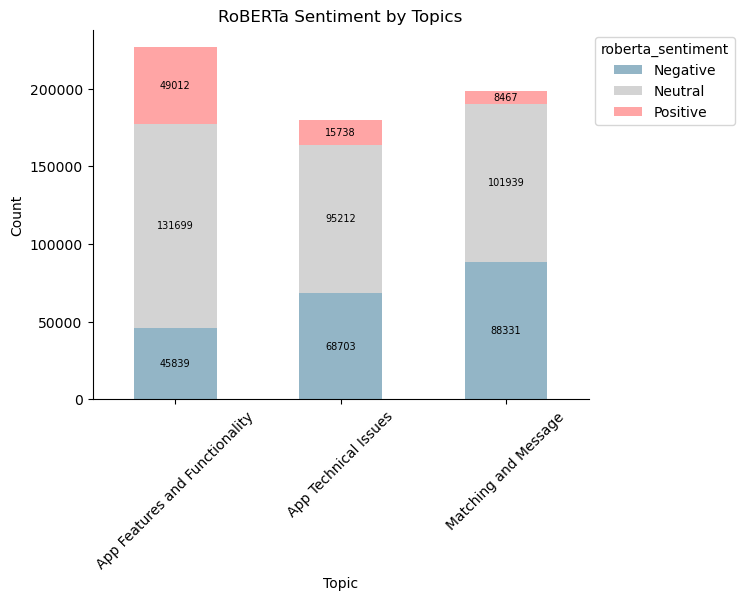

In [209]:
# Count the occurrences of a specific topic, grouped by the Roberta sentiment column
counts = app_reviews_pos.groupby(['topic_label', 'roberta_sentiment']).size().unstack()

# Create a custom color palette 
custom_palette = ['#93B5C6', '#D3D3D3', '#FFA5A5']

# Create a bar plot using seaborn with custom colors
sns.set_palette(custom_palette)
ax=counts.plot(kind='bar', stacked=True)

# Set the labels for x-axis and y-axis
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels inside each bar
for i, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2
    count = counts.transpose().values.flatten()[i]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the title of the bar plot
plt.title('RoBERTa Sentiment by Topics')
# Move the legend to the bottom
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='roberta_sentiment')
# Show the bar plot
plt.show()

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


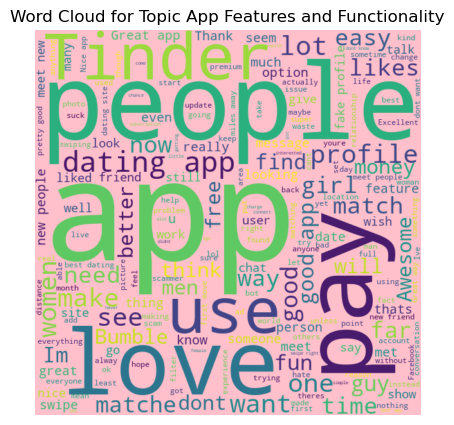

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


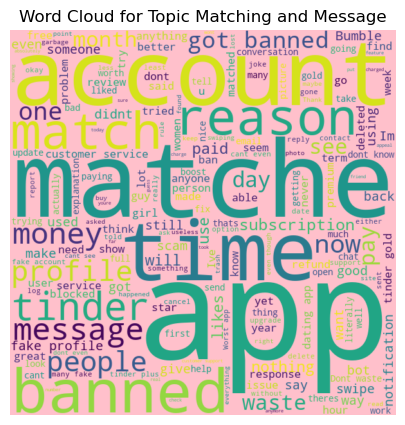

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


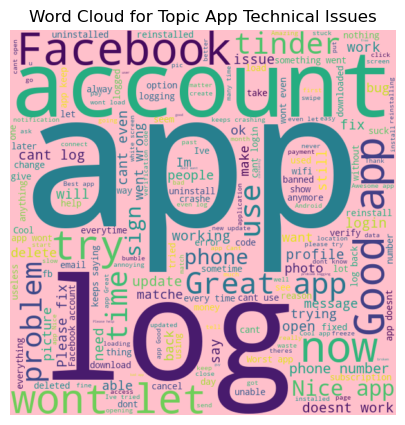

In [210]:
# Get unique topic labels
unique_topics = app_reviews_pos['topic_label'].unique()

# Generate word cloud for each topic
for topic in unique_topics:
    # Filter rows for the specific topic
    topic_text = ' '.join(app_reviews_pos[app_reviews_pos['topic_label'] == topic]['content'])

    # Generate word cloud for the topic
    topic_wordcloud = WordCloud(width=600, height=600, background_color='pink').generate(topic_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(topic_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Topic {topic}')
    plt.show()